In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

/home/jgauthie/om2/miniconda/envs/huggingface/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# render the expensive figures?
RENDER_ALL_FIGURES = True

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# save figures?
FIGURE_DIR = RESULTS_DIR / "figures"
FIGURE_DIR.mkdir(exist_ok=True)
SAVE_FIGURES = True

## Code suite metadata

In [3]:
# Format: suite_first_token -> [((expected_grammatical_region, expected_grammatical_condition),
#                                (expected_ungrammatical_region, expected_ungrammatical_condition), ...]
# 
# Will be used to compute margins between region-condition values.

margin_measures = {
    "fgd_pp": [((8, "that_nogap"), (8, "what_nogap")),
               ((9, "what_gap"), (9, "that_gap"))],
    "fgd_subject": [((4, "that_nogap"), (4, "what_nogap")),
                    ((5, "what_gap"), (5, "that_gap"))],
    "fgd_object": [((6, "that_nogap"), (6, "what_nogap")),
                   ((7, "what_gap"), (7, "that_gap"))],
    
    "number_prep": [((7, "match_sing"), (7, "mismatch_sing")),
                    ((7, "match_plural"), (7, "mismatch_plural"))],
    "number_src": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],
    "number_orc": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],

    "reflexive_prep_fem": [((8, "match_sing"), (8, "mismatch_sing")),
                           ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_prep_masc": [((8, "match_sing"), (8, "mismatch_sing")),
                            ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    
    "subordination_src-src": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_orc-orc": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_pp-pp": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                            ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    
    "mvrr": [((6, "unreduced_ambig"), (6, "reduced_ambig")),
             ((6, "reduced_unambig"), (6, "reduced_ambig"))],
}

In [4]:
critical_regions = {suite: set(region for region_comparison in region_comparisons for region in region_comparison)
                    for suite, region_comparisons in margin_measures.items()}
critical_region_strs = {suite: {" ".join(map(str, region)) for region in regions} for suite, regions in critical_regions.items()}
critical_region_strs

{'fgd_pp': {'8 that_nogap', '8 what_nogap', '9 that_gap', '9 what_gap'},
 'fgd_subject': {'4 that_nogap', '4 what_nogap', '5 that_gap', '5 what_gap'},
 'fgd_object': {'6 that_nogap', '6 what_nogap', '7 that_gap', '7 what_gap'},
 'number_prep': {'7 match_plural',
  '7 match_sing',
  '7 mismatch_plural',
  '7 mismatch_sing'},
 'number_src': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'number_orc': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_prep_fem': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_src_fem': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_orc_fem': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_prep_masc': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_src_masc': {'9 match_plural',
  '9 match_sing',
 

## Load results

In [5]:
OUTPUT_DIR = Path("output")

In [6]:
prediction_paths = list(OUTPUT_DIR.glob("*.predictions.csv"))
prediction_dfs = [pd.read_csv(path) for path in tqdm(prediction_paths)]
prediction_df_keys = [(path.name.split(".")[0], path.name.split(".")[1])
                      for path in prediction_paths]
prediction_df = pd.concat(prediction_dfs, names=["suite", "prefix_suite"], keys=prediction_df_keys) \
    .drop(columns=["prefix_suite"])

# Drop duplicates
prediction_df = prediction_df[~prediction_df.index.duplicated(keep="first")]

  0%|          | 0/256 [00:00<?, ?it/s]

In [7]:
meta_vars = ["num_prefix_sentences", "prefix_length", "prefix_length_bin", "canonical_suite", "suite_category", "item_number"]

prediction_cols = ["prediction_0", "prediction_1"]# DEV [key for key in prediction_df.columns if key.startswith("prediction_")]
prediction_df["prediction_ALL"] = prediction_df[prediction_cols].all(axis=1)
prediction_cols += ["prediction_ALL"]

prediction_df["first_item"] = prediction_df.used_item_numbers.str.split().str.get(0)

canonical_suite = {suite_name: next(can_suite for can_suite in critical_regions.keys()
                                    if can_suite in suite_name)
                   for suite_name in set(prediction_df.index.get_level_values("suite"))}

prediction_df["canonical_suite"] = prediction_df.index.get_level_values("suite").map(canonical_suite)
prediction_df["suite_category"] = prediction_df.canonical_suite.str.split("_").apply(lambda parts: "_".join(parts[:-1]) if len(parts) > 1 else parts[0])
prediction_df["critical_region"] = prediction_df.canonical_suite.map(critical_regions)

prediction_df["num_prefix_sentences"] = prediction_df.used_conditions.str.count(" ").fillna(0)
prediction_df["prefix_length_bin"] = pd.cut(prediction_df.prefix_length, 20).astype(str)

prediction_df

item_number  prediction_0  \
suite                 prefix_suite                                            
fgd_object            fgd_object            0               1          True   
                                            1               2          True   
                                            2               3          True   
                                            3               4          True   
                                            4               5          True   
...                                                       ...           ...   
subordination_src-src subordination_src-src 1943         1944          True   
                                            1944         1945          True   
                                            1945         1946          True   
                                            1946         1947          True   
                                            1947         1948          True   

                                                  prediction_1  \
suite                 prefix_suite                               
fgd_object            fgd_object            0             True   
                                            1             True   
                                            2             True   
                                            3             True   
                                            4             True   
...                                                        ...   
subordination_src-src subordination_src-src 1943          True   
                                            1944          True   
                                            1945         False   
                                            1946          True   
                                            1947          True   

                                                                                  used_item_numbers  \
suite                 prefix_suite                                                                    
fgd_object            fgd_object            0                                                     1   
                                            1                                                     2   
                                            2                                                     3   
                                            3                                                     4   
                                            4                                                     5   
...                                                                                             ...   
subordination_src-src subordination_src-src 1943  15 23 2 5 13 4 15 11 17 19 9 1 4 7 6 10 20 18 ...   
                                            1944  9 18 21 3 1 12 2 22 16 14 20 11 3 18 8 5 6 23 ...   
                                            1945  4 16 7 3 2 15 6 1 22 7 16 23 21 23 19 14 22 18...   
                                            1946  19 16 11 23 4 10 15 21 20 10 23 13 3 11 14 16 ...   
                                            1947  17 8 14 15 18 21 18 11 10 16 23 22 21 6 5 2 20...   

                                                                                    used_conditions  \
suite                 prefix_suite                                                                    
fgd_object            fgd_object            0                                                   NaN   
                                            1                                                   NaN   
                                            2                                                   NaN   
                                            3                                                   NaN   
                                            4                                                   NaN   
...                                                                                             ...   

In [8]:
region_paths = list(OUTPUT_DIR.glob("*.regions.csv"))
region_dfs = [pd.read_csv(path) for path in tqdm(region_paths)]
region_df_keys = [(path.name.split(".")[0], path.name.split(".")[1])
                   for path in region_paths]
region_df = pd.concat(region_dfs, names=["suite", "prefix_suite"], keys=region_df_keys) \
    .drop(columns=["prefix_suite"])

# Drop duplicates
region_df = region_df[~region_df.index.duplicated(keep="first")]

# Bring in metadata from predictions df
region_df = pd.merge(region_df.reset_index(), prediction_df[meta_vars].reset_index(),
                     on=["suite", "prefix_suite", "item_number"])

region_df

  0%|          | 0/256 [00:00<?, ?it/s]

,suite,prefix_suite,level_2_x,item_number,value,condition,region_number,level_2_y,num_prefix_sentences,prefix_length,prefix_length_bin,canonical_suite,suite_category
0,fgd_object,fgd_object,0,1,8.975654,what_nogap,2,0,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
1,fgd_object,fgd_object,1976,1,4.586143,what_nogap,3,0,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
2,fgd_object,fgd_object,3952,1,26.174854,what_nogap,4,0,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
3,fgd_object,fgd_object,5928,1,16.165907,what_nogap,5,0,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
4,fgd_object,fgd_object,7904,1,16.567860,what_nogap,6,0,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16322931,subordination_src-src,subordination_src-src,38959,1948,6.122275,no-sub_matrix,6,1947,24.0,506,"(480.6, 507.3]",subordination_src-src,subordination
16322932,subordination_src-src,subordination_src-src,40907,1948,2524.694824,sub_no-matrix,1,1947,24.0,506,"(480.6, 507.3]",subordination_src-src,subordination
16322933,subordination_src-src,subordination_src-src,42855,1948,2524.694824,no-sub_no-matrix,1,1947,24.0,506,"(480.6, 507.3]",subordination_src-src,subordination
16322934,subordination_src-src,subordination_src-src,44803,1948,2524.694824,sub_matrix,1,1947,24.0,506,"(480.6, 507.3]",subordination_src-src,subordination


In [9]:
sns.set_context("talk")

## Cross-suite prefixing analysis

In [10]:
def get_best_prediction_performance(prefixed_suite):
    return prefixed_suite.groupby("num_prefix_sentences")[prediction_cols].mean().max()
cross_perfs = prediction_df.groupby(["suite", "prefix_suite"]).apply(get_best_prediction_performance)
cross_perfs

prediction_0  prediction_1  \
suite                 prefix_suite                                        
fgd_object            fgd_object                 1.000000           1.0   
                      fgd_pp                     0.983607           1.0   
                      fgd_subject                1.000000           1.0   
                      mvrr                       1.000000           1.0   
                      number_orc                 1.000000           1.0   
...                                                   ...           ...   
subordination_src-src reflexive_src_fem          1.000000           1.0   
                      reflexive_src_masc         1.000000           1.0   
                      subordination_orc-orc      1.000000           1.0   
                      subordination_pp-pp        1.000000           1.0   
                      subordination_src-src      1.000000           1.0   

                                             prediction_ALL  
suite                 prefix_suite                           
fgd_object            fgd_object                   1.000000  
                      fgd_pp                       0.983607  
                      fgd_subject                  1.000000  
                      mvrr                         1.000000  
                      number_orc                   1.000000  
...                                                     ...  
subordination_src-src reflexive_src_fem            1.000000  
                      reflexive_src_masc           1.000000  
                      subordination_orc-orc        1.000000  
                      subordination_pp-pp          1.000000  
                      subordination_src-src        1.000000  

[256 rows x 3 columns]

In [11]:
def plot_cross_perfs(cross_perfs: pd.DataFrame, **kwargs):
    cross_perfs = cross_perfs.sort_index(axis=0).sort_index(axis=1)
    f, axs = plt.subplots(len(prediction_cols), 1, figsize=(25, 30))
    for ax, col_name in zip(axs, prediction_cols):
        sns.heatmap(cross_perfs[col_name].unstack(), ax=ax, annot=True, **kwargs)
        ax.set_title(col_name)
    plt.tight_layout()
    return f, axs

In [ ]:
f, axs = plot_cross_perfs(cross_perfs)
f.suptitle("Cross-suite performance\nat any prefix length")
plt.tight_layout()

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / "cross_suite.max.pdf")

### Redo with matched lengths

In [13]:
# Pick the minimum number of prefix sentences for which all suite/prefix-suite combinations have data
max_sentences = prediction_df.groupby(["suite", "prefix_suite"]).num_prefix_sentences.max().min()
print(max_sentences)

cross_perfs_maxlen = prediction_df.groupby(["suite", "prefix_suite"]).apply(lambda xs: xs.loc[xs.num_prefix_sentences == max_sentences, prediction_cols].mean())
cross_perfs_maxlen.head()

24.0


prediction_0  prediction_1  prediction_ALL
suite      prefix_suite                                            
fgd_object fgd_object        1.000000      0.983607        0.983607
           fgd_pp            0.622951      1.000000        0.622951
           fgd_subject       0.936508      1.000000        0.936508
           mvrr              1.000000      1.000000        1.000000
           number_orc        1.000000      0.927273        0.927273

In [ ]:
f, axs = plot_cross_perfs(cross_perfs_maxlen)
f.suptitle("Cross-suite performance\nat a single prefix length which is compatible for all prefixes")
plt.tight_layout()

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / f"cross_suite.len-{int(max_sentences)}.pdf")

### Plot changes from baseline rather than absolute accuracy, at matched lengths

In [15]:
baseline_perfs = prediction_df.reset_index().groupby("suite").apply(lambda xs: xs[xs.prefix_suite == xs.suite][prediction_cols].mean())
baseline_perfs

,prediction_0,prediction_1,prediction_ALL
suite,,,
fgd_object,0.987854,0.993421,0.981275
fgd_pp,0.852733,0.977227,0.831984
fgd_subject,0.961558,0.980779,0.942337
mvrr,0.859218,0.700401,0.660822
number_orc,0.738869,0.527264,0.361681
number_prep,0.893447,0.758379,0.683842
number_src,0.894447,0.734867,0.657329
reflexive_orc_fem,0.833917,0.931466,0.766883
reflexive_orc_masc,0.887444,0.963482,0.854427


In [16]:
def get_best_prediction_improvement_pct(rows, matched_lengths=True):
    suite, prefixed_suite = rows.name
    
    if matched_lengths:
        rows = rows[rows.num_prefix_sentences == max_sentences]
    mean_perfs = rows.groupby("num_prefix_sentences")[prediction_cols].mean()
    
    try:
        baseline_perf = baseline_perfs.loc[suite]
    except KeyError:
        baseline_perf = np.nan
        
    diff_of_means = mean_perfs - baseline_perf
    max_diff = diff_of_means.max()
    return max_diff / baseline_perf * 100

cross_improvement_pcts = prediction_df.groupby(["suite", "prefix_suite"]).apply(get_best_prediction_improvement_pct)

In [ ]:
f, axs = plot_cross_perfs(cross_improvement_pcts, center=0, cmap="seismic")

if SAVE_FIGURES:
    f.savefig(FIGURE_DIR / "cross_suite_pcts.max.pdf")

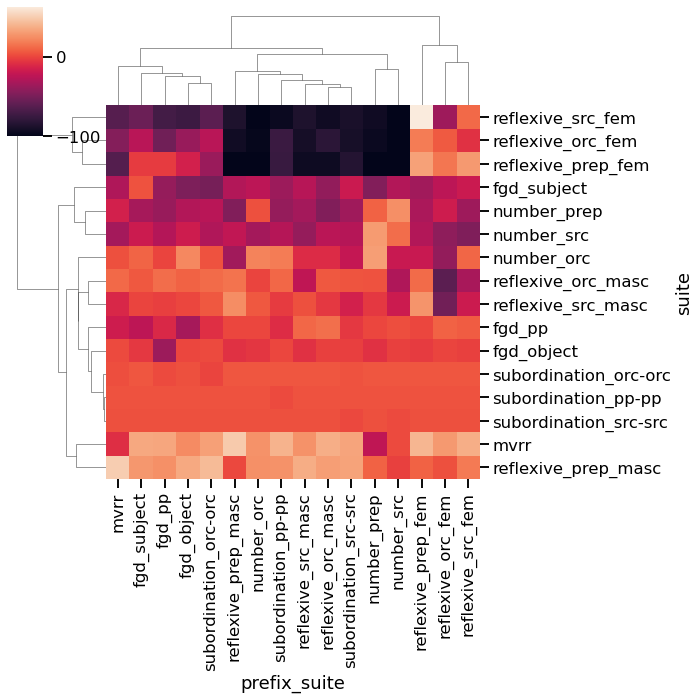

In [18]:
sns.clustermap(cross_improvement_pcts["prediction_ALL"].unstack())

## Prediction results

In [19]:
# Get baseline accuracy results.
prediction_df[prediction_df.used_conditions.isna()] \
    [prediction_cols + ["canonical_suite"]] \
    .melt(id_vars=["canonical_suite"]).groupby(["canonical_suite", "variable"]).value.mean().dropna()

canonical_suite        variable      
fgd_object             prediction_0      1.000000
                       prediction_1      0.958333
                       prediction_ALL    0.958333
fgd_pp                 prediction_0      0.916667
                       prediction_1      0.958333
                       prediction_ALL    0.875000
fgd_subject            prediction_0      0.625000
                       prediction_1      0.875000
                       prediction_ALL    0.500000
mvrr                   prediction_0      1.000000
                       prediction_1      0.892857
                       prediction_ALL    0.892857
number_orc             prediction_0      0.631579
                       prediction_1      0.473684
                       prediction_ALL    0.421053
number_prep            prediction_0      0.789474
                       prediction_1      0.526316
                       prediction_ALL    0.473684
number_src             prediction_0      0.842105
            

<AxesSubplot:xlabel='prefix_length', ylabel='Count'>

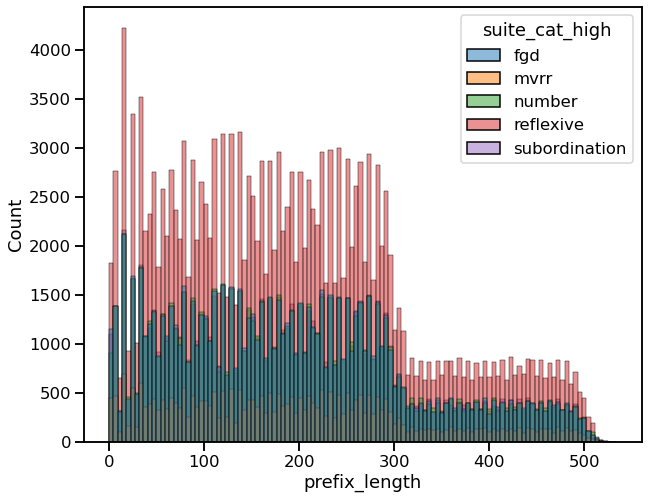

In [20]:
plt.subplots(figsize=(10, 8))
sns.histplot(data=prediction_df.assign(suite_cat_high=prediction_df.suite_category.str.split("_").str[0]), x="prefix_length", hue="suite_cat_high")

In [21]:
prediction_df_melt = prediction_df.reset_index()
prediction_df_melt = prediction_df_melt.loc[:, prediction_df_melt.columns.str.startswith(("prediction", "prefix_suite") + tuple(meta_vars))] \
    .melt(id_vars=meta_vars + ["prefix_suite"], var_name="prediction", value_name="correct")
prediction_df_melt

,num_prefix_sentences,prefix_length,prefix_length_bin,canonical_suite,suite_category,item_number,prefix_suite,prediction,correct
0,0.0,0,"(-0.534, 26.7]",fgd_object,fgd,1,fgd_object,prediction_0,True
1,0.0,0,"(-0.534, 26.7]",fgd_object,fgd,2,fgd_object,prediction_0,True
2,0.0,0,"(-0.534, 26.7]",fgd_object,fgd,3,fgd_object,prediction_0,True
3,0.0,0,"(-0.534, 26.7]",fgd_object,fgd,4,fgd_object,prediction_0,True
4,0.0,0,"(-0.534, 26.7]",fgd_object,fgd,5,fgd_object,prediction_0,True
...,...,...,...,...,...,...,...,...,...
2032635,24.0,500,"(480.6, 507.3]",subordination_src-src,subordination,1944,subordination_src-src,prediction_ALL,True
2032636,24.0,489,"(480.6, 507.3]",subordination_src-src,subordination,1945,subordination_src-src,prediction_ALL,True
2032637,24.0,498,"(480.6, 507.3]",subordination_src-src,subordination,1946,subordination_src-src,prediction_ALL,False
2032638,24.0,488,"(480.6, 507.3]",subordination_src-src,subordination,1947,subordination_src-src,prediction_ALL,True


In [ ]:
if RENDER_ALL_FIGURES:
    g = sns.FacetGrid(data=prediction_df_melt, height=8, row="canonical_suite", col="prefix_suite")
    g.map(sns.lineplot, "num_prefix_sentences", "correct", "prediction")
    g.add_legend()

    plt.xlabel("# prefix sentences")
    plt.ylabel("Prediction accuracy")
    
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "prediction_accuracy.num_prefix_sentences.pdf")

In [23]:
# Too noisy. Use binned plot instead.
# sns.lineplot(data=prediction_df, x="prefix_length", y="prediction_0")

# plt.xlabel("# prefix tokens")
# plt.ylabel("Prediction accuracy")

In [ ]:
if RENDER_ALL_FIGURES:
    g = sns.FacetGrid(data=prediction_df_melt, height=8, row="canonical_suite", col="prefix_suite")
    g.map(sns.lineplot, "prefix_length_bin", "correct", "prediction")
    g.add_legend()

    for ax in g.axes.ravel():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

    plt.xlabel("# prefix tokens (binned)")
    plt.ylabel("Prediction accuracy")
    
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "prediction_accuracy.prefix_length_bin.pdf")

## Margins

In [25]:
def filter_critical_regions(suite_df):
    critical_strs = critical_region_strs[suite_df.canonical_suite.iloc[0]]
    is_critical = suite_df.region_number.astype(str).str.cat(suite_df.condition, " ").isin(critical_strs)
    return suite_df[is_critical]

critical_region_df = region_df.groupby(["suite", "canonical_suite"], as_index=False) \
    .apply(filter_critical_regions)
critical_region_df

suite           prefix_suite  level_2_x  \
0  4                    fgd_object             fgd_object       7904   
   12                   fgd_object             fgd_object      23712   
   20                   fgd_object             fgd_object      39520   
   27                   fgd_object             fgd_object      53352   
   38                   fgd_object             fgd_object       7905   
...                            ...                    ...        ...   
15 16322907  subordination_src-src  subordination_src-src      38958   
   16322916  subordination_src-src  subordination_src-src       9739   
   16322921  subordination_src-src  subordination_src-src      19479   
   16322926  subordination_src-src  subordination_src-src      29219   
   16322931  subordination_src-src  subordination_src-src      38959   

             item_number      value         condition  region_number  \
0  4                   1  16.567860        what_nogap              6   
   12                  1  12.456110        that_nogap              6   
   20                  1  10.868265          what_gap              7   
   27                  1  13.471580          that_gap              7   
   38                  2  17.799953        what_nogap              6   
...                  ...        ...               ...            ...   
15 16322907         1947  47.486374     no-sub_matrix              6   
   16322916         1948  11.324101     sub_no-matrix              6   
   16322921         1948   4.925347  no-sub_no-matrix              6   
   16322926         1948   6.059862        sub_matrix              6   
   16322931         1948   6.122275     no-sub_matrix              6   

             level_2_y  num_prefix_sentences  prefix_length prefix_length_bin  \
0  4                 0                   0.0              0    (-0.534, 26.7]   
   12                0                   0.0              0    (-0.534, 26.7]   
   20                0                   0.0              0    (-0.534, 26.7]   
   27                0                   0.0              0    (-0.534, 26.7]   
   38                1                   0.0              0    (-0.534, 26.7]   
...                ...                   ...            ...               ...   
15 16322907       1946                  24.0            488    (480.6, 507.3]   
   16322916       1947                  24.0            506    (480.6, 507.3]   
   16322921       1947                  24.0            506    (480.6, 507.3]   
   16322926       1947                  24.0            506    (480.6, 507.3]   
   16322931       1947                  24.0            506    (480.6, 507.3]   

                   canonical_suite suite_category  
0  4                    fgd_object            fgd  
   12                   fgd_object            fgd  
   20                   fgd_object            fgd  
   27                   fgd_object            fgd  
   38                   fgd_object            fgd  
...                            ...            ...  
15 16322907  subordination_src-src  subordination  
   16322916  subordination_src-src  subordination  
   16322921  subordination_src-src  subordination  
   16322926  subordination_src-src  subordination  
   16322931  subordination_src-src  subordination  

[2000772 rows x 13 columns]

In [ ]:
if RENDER_ALL_FIGURES:
    g = sns.FacetGrid(data=critical_region_df, height=8, row="canonical_suite", col="prefix_suite", sharey=False)
    g.map(sns.lineplot, "prefix_length_bin", "value", "condition")
    for ax in g.axes.ravel():
        ax.legend()

    plt.xticks(rotation=35)
    plt.legend(loc=(1.04,0))
    plt.xlabel("# prefix tokens (binned)")
    plt.ylabel("Raw surprisal")
    
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "surprisal.prefix_length_bin.pdf")

In [27]:
# g = sns.catplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", alpha=0.1,
#                 height=10)
# sns.lineplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", ax=g.ax, legend=False)

# plt.legend(loc=(1.04,0))
# plt.xlabel("# prefix sentences")
# plt.ylabel("Raw surprisal")

In [28]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["region_number", "condition"]).value
    
    margins = pd.Series([rows.loc[ungrammatical] - rows.loc[grammatical]
                         for grammatical, ungrammatical in margin_spec])
    return margins

margin_sizes = critical_region_df.groupby(["suite", "prefix_suite", "item_number"]).apply(compute_margins)
margin_sizes = pd.merge(margin_sizes.reset_index(), prediction_df[meta_vars].reset_index(),
                        on=["suite", "prefix_suite", "item_number"])
margin_sizes

,suite,prefix_suite,item_number,0,1,level_2,num_prefix_sentences,prefix_length,prefix_length_bin,canonical_suite,suite_category
0,fgd_object,fgd_object,1,4.111750,2.603314,0,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
1,fgd_object,fgd_object,2,5.890624,2.987965,1,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
2,fgd_object,fgd_object,3,7.325131,1.937300,2,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
3,fgd_object,fgd_object,4,4.117939,3.818717,3,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
4,fgd_object,fgd_object,5,4.211559,3.049620,4,0.0,0,"(-0.534, 26.7]",fgd_object,fgd
...,...,...,...,...,...,...,...,...,...,...,...
508155,subordination_src-src,subordination_src-src,1944,6.072255,13.951820,1943,24.0,500,"(480.6, 507.3]",subordination_src-src,subordination
508156,subordination_src-src,subordination_src-src,1945,6.689662,3.908840,1944,24.0,489,"(480.6, 507.3]",subordination_src-src,subordination
508157,subordination_src-src,subordination_src-src,1946,3.705912,-0.950360,1945,24.0,498,"(480.6, 507.3]",subordination_src-src,subordination
508158,subordination_src-src,subordination_src-src,1947,3.887867,6.001457,1946,24.0,488,"(480.6, 507.3]",subordination_src-src,subordination


In [29]:
# Prefer binned figure below.

# sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length"], value_vars=["sing", "plur"], var_name="Prediction"),
#              x="prefix_length", y="value", hue="Prediction")

# plt.legend(loc=(1.04, 0))
# plt.axhline(0, color="gray", linestyle="--")
# plt.xlabel("# prefix tokens")
# plt.ylabel("Grammaticality margin (bits)")

In [ ]:
if RENDER_ALL_FIGURES:
    margin_sizes["prefix_length_bin"] = pd.cut(margin_sizes.prefix_length, 10).astype(str)
    to_plot = margin_sizes.melt(id_vars=meta_vars + ["prefix_suite"],
                                value_vars=[0, 1], var_name="Prediction")
    g = sns.catplot(data=to_plot, row="canonical_suite", col="prefix_suite",
                    x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
    g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

    for ax in g.axes.flat:
        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xticks(ax.get_xticks(), rotation=35)
        ax.set_xlabel("# prefix tokens (binned)")
        ax.set_ylabel("Grammaticality margin (bits)")
        
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "margins.prefix_length_bin.pdf")

In [ ]:
# # DEV recompute predictions as a sanity check
# recompute_preds = margin_sizes.assign(**{f"correct_{idx}": margin_sizes[idx] > 0
#                                          for idx in [col for col in margin_sizes.columns if isinstance(col, int)]})

In [ ]:
# sns.lineplot(data=recompute_preds[["prefix_length_bin", "correct_0", "correct_1"]].melt(id_vars=["prefix_length_bin"]),
#              x="prefix_length_bin", y="value", hue="variable")

In [ ]:
# # recompute_preds[recompute_preds.prefix_length == 0].groupby("canonical_suite").correct.mean()
# recompute_preds[recompute_preds.prefix_length == 0][["correct_0", "correct_1"]].melt().groupby("variable").value.mean()

## Total probability margins

In [ ]:
total_surprisals = region_df.groupby(["suite", "canonical_suite", "prefix_suite", "item_number", "condition"]).value.sum().reset_index()
total_surprisals

In [ ]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["condition"]).value
    return pd.Series([rows.loc[ungrammatical_cond] - rows.loc[grammatical_cond]
                      for (_, grammatical_cond), (_, ungrammatical_cond) in margin_spec])

total_surprisal_margins = total_surprisals.groupby(["suite", "prefix_suite", "item_number"]).apply(compute_margins)
total_surprisal_margins

In [ ]:
# Bring back metadata
total_surprisal_margins = pd.merge(total_surprisal_margins.reset_index(), prediction_df[meta_vars].reset_index(),
                                   on=["suite", "prefix_suite", "item_number"])

In [ ]:
if RENDER_ALL_FIGURES:
    to_plot = total_surprisal_margins.melt(id_vars=["prefix_length_bin", "canonical_suite", "prefix_suite"],
                                           value_vars=[0, 1], var_name="Prediction")
    g = sns.catplot(data=to_plot, row="canonical_suite", col="prefix_suite",
                    x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
    g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

    for ax in g.axes.flat:
        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xticks(ax.get_xticks(), rotation=35)
        ax.set_xlabel("# prefix tokens (binned)")
        ax.set_ylabel("Grammaticality margin (bits)")
        
    if SAVE_FIGURES:
        g.savefig(FIGURE_DIR / "total_surprisal_margin.prefix_length_bin.pdf")

## Save results data

In [ ]:
prediction_df.to_csv(RESULTS_DIR / "predictions.csv")
# region_df.to_csv(RESULTS_DIR / "regions.csv", index=False)

cross_perfs.to_csv(RESULTS_DIR / "cross_suite.max.csv")
cross_perfs_maxlen.to_csv(RESULTS_DIR / f"cross_suite.len-{int(max_sentences)}.csv")
cross_improvement_pcts.to_csv(RESULTS_DIR / "cross_suite_pcts.max.csv")

In [41]:
# critical_region_df.to_csv(RESULTS_DIR / "critical_regions.csv")
margin_sizes.to_csv(RESULTS_DIR / "margins.csv")
total_surprisals.to_csv(RESULTS_DIR / "total_surprisals.csv")
total_surprisal_margins.to_csv(RESULTS_DIR / "total_surprisal_margins.csv")